##Data Preprocessing

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
!pip install scikit-learn pandas matplotlib streamlit gradio colabcode

In [75]:
df = pd.read_csv('/content/adult 3.csv')

In [76]:
df.replace('?', pd.NA, inplace=True)

In [77]:
df.dropna(inplace=True)

In [78]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [79]:
X = df.drop("income", axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

In [81]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_acc = accuracy_score(y_test, log_model.predict(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [82]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))

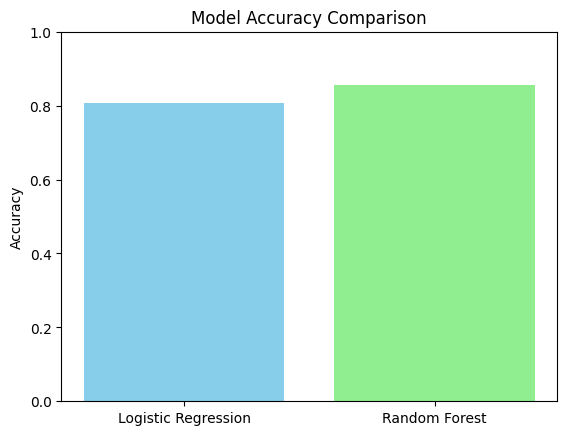

In [83]:
# Plot accuracy comparison
models = ['Logistic Regression', 'Random Forest']
accuracies = [log_acc, rf_acc]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Select best model
best_model = rf_model if rf_acc > log_acc else log

##Save Best Model & Label Encoders


In [84]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

## Create Streamlit App

In [91]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load trained model
model = joblib.load("best_model.pkl")

# Page config
st.set_page_config(page_title="Employee Salary Classification", page_icon="💼", layout="centered")

# Custom CSS for dark mode improvements
st.markdown("""
    <style>
    body {
        background-color: #0e1117;
        color: #FAFAFA;
    }
    .stApp {
        background-color: #0e1117;
        color: #FAFAFA;
    }
    .stSidebar {
        background-color: #1c1e26;
        color: #FAFAFA;
    }
    .block-container {
        padding-top: 2rem;
        padding-bottom: 2rem;
    }
    h1, h2, h3, h4, h5 {
        color: #FAFAFA;
    }
    .main > div {
        padding: 1rem 2rem;
        border-radius: 10px;
        background-color: #161a22;
        box-shadow: 0px 0px 10px #00000033;
    }
    .css-1cpxqw2 edgvbvh3 {
        background-color: #1c1e26 !important;
    }
    .stButton>button {
        background-color: #5c6bc0;
        color: white;
        border: none;
        padding: 0.5rem 1rem;
        border-radius: 5px;
    }
    .stButton>button:hover {
        background-color: #3f51b5;
    }
    .dataframe {
        background-color: #1e2128;
        color: #FAFAFA;
    }
    </style>
""", unsafe_allow_html=True)

# Title
st.markdown("<h1 style='text-align: center;'>💼 Employee Salary Classification</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center; color: #b0b3b8;'>Predict whether an employee earns >50K or ≤50K based on input features.</p>", unsafe_allow_html=True)
st.markdown("---")

# Sidebar
st.sidebar.header("📝 Input Employee Details")

# Sidebar inputs
age = st.sidebar.slider("📅 Age", 18, 65, 30)
education = st.sidebar.selectbox("🎓 Education Level", [
    "Bachelors", "Masters", "PhD", "HS-grad", "Assoc", "Some-college"
])
occupation = st.sidebar.selectbox("🛠️ Job Role", [
    "Tech-support", "Craft-repair", "Other-service", "Sales",
    "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct",
    "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv",
    "Protective-serv", "Armed-Forces"
])
hours_per_week = st.sidebar.slider("⏱️ Hours per Week", 1, 80, 40)
experience = st.sidebar.slider("🏅 Years of Experience", 0, 40, 5)

# Input dataframe
input_df = pd.DataFrame({
    'age': [age],
    'education': [education],
    'occupation': [occupation],
    'hours-per-week': [hours_per_week],
    'experience': [experience]
})

st.markdown("### 🔍 Input Preview")
st.dataframe(input_df, use_container_width=True)

# Prediction
if st.button("🔮 Predict Salary Class"):
    prediction = model.predict(input_df)
    predicted_class = prediction[0]

    if predicted_class == ">50K":
        st.success("💰 Prediction: Employee earns more than 50K!")
    else:
        st.warning("📉 Prediction: Employee earns 50K or less.")

# Batch prediction
st.markdown("---")
st.markdown("### 📁 Batch Prediction (CSV Upload)")

uploaded_file = st.file_uploader("Upload a CSV file for multiple predictions", type="csv")

if uploaded_file is not None:
    batch_data = pd.read_csv(uploaded_file)
    st.write("📄 Uploaded Data Preview:")
    st.dataframe(batch_data.head(), use_container_width=True)

    batch_preds = model.predict(batch_data)
    batch_data['PredictedClass'] = batch_preds

    st.markdown("### ✅ Batch Predictions")
    st.dataframe(batch_data.head(), use_container_width=True)

    # Download button
    csv = batch_data.to_csv(index=False).encode('utf-8')
    st.download_button("📥 Download CSV with Predictions", csv, file_name='predicted_classes.csv', mime='text/csv')


Overwriting app.py


In [92]:
!pip install pyngrok streamlit

In [93]:
!pkill ngrok

In [94]:
from pyngrok import ngrok
ngrok.set_auth_token("3067lkzikgwTWgLR52d6LnNFigp_xhsbo7VHtdrvf2T1NW6z")

In [95]:
!streamlit run app.py &> streamlit_log.txt &

In [96]:
public_url = ngrok.connect("http://localhost:8501")
print("Streamlit App URL:", public_url)

Streamlit App URL: NgrokTunnel: "https://3f66f9cc1475.ngrok-free.app" -> "http://localhost:8501"
